## Main Objective
The main objective is to develop a Book Recommendation System based on ratings and content information.  
A Book Recommendation System is a data-driven application that suggests books to users based on their preferences and behaviour.   
It aims to enhance user experience by providing personalized book recommendations, thereby increasing user engagement and satisfaction.   

### Data Understanding
The dataset has the following features:
1. **bookID**: A unique identifier for each book.
2. **title**: The title of the book.
3. **authors**: The author(s) of the book.
4. **average_rating**: The average rating of the book, indicating user satisfaction with the book.

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Farhad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
dataset = pd.read_csv("datasets/books_data.csv")

In [21]:
dataset.head()

,bookID,title,authors,average_rating
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78


In [22]:
dataset.isnull().sum()

bookID            0
title             0
authors           0
average_rating    0
dtype: int64

In [5]:
dataset.shape

(11127, 4)

In [23]:
# Keep only rows where 'average_rating' contains valid numeric values
df_cleaned = dataset[dataset['average_rating'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

### Exploratory Data Analysis
#### How is the overall distribution of average ratings across all books?

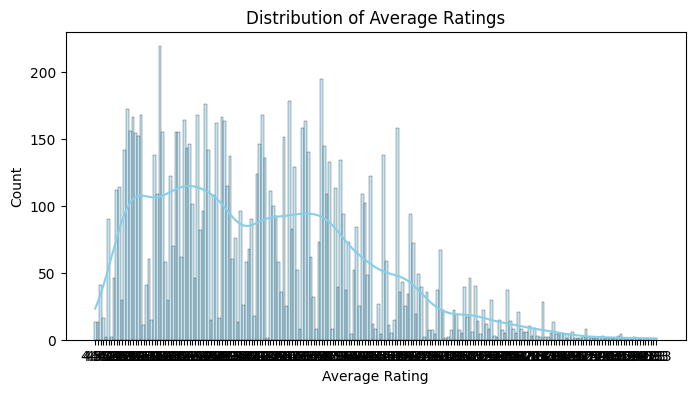

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['average_rating'], bins=30, kde=True, color='skyblue')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.title('Distribution of Average Ratings')
plt.show()

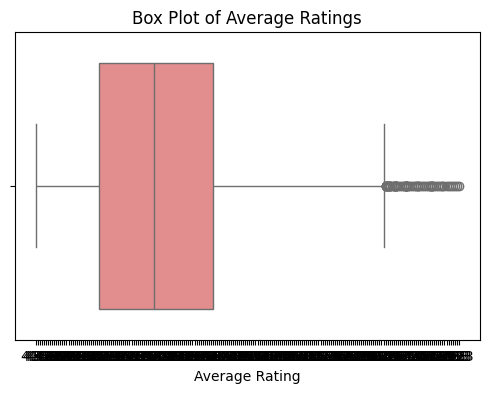

In [26]:
# Box plot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_cleaned['average_rating'], color='lightcoral')
plt.xlabel("Average Rating")
plt.title("Box Plot of Average Ratings")
plt.show()

> These observations suggest that most books have moderate-to-good ratings, but a few books with exceptionally high ratings are pulling the distribution to the right. The right skew in the histogram indicates that lower ratings are less common, while the boxplot outliers highlight books that received significantly higher ratings than the majority. 

#### Which books stand out as exceptionally high or low in rating, and what unique characteristics (e.g., title patterns or specific authors) do they share?

In [54]:
# Find max and min rating values
max_rating = df_cleaned["average_rating"].max()
min_rating = df_cleaned["average_rating"].min()

# Get all books with the highest rating
highest_rated_books = df_cleaned[df_cleaned["average_rating"] == max_rating]

# Get all books with the lowest rating
lowest_rated_books = df_cleaned[df_cleaned["average_rating"] == min_rating]

In [38]:
print(f"Number of books with highest rating {max_rating} is: {highest_rated_books.shape[0]}")
print(f"Number of books with lowest rating {min_rating} is: {lowest_rated_books.shape[0]}")

Number of books with highest rating 5.00 is: 22
Number of books with lowest rating 0.00 is: 25


In [45]:
highest_rated_books.head()

,bookID,title,authors,average_rating
624,2034,Comoediae 1: Acharenses/Equites/Nubes/Vespae/P...,Aristophanes/F.W. Hall/W.M. Geldart,5.00
786,2560,Willem de Kooning: Late Paintings,Julie Sylvester/David Sylvester,5.00
855,2843,Literature Circle Guide: Bridge to Terabithia:...,Tara MacCarthy,5.00
1243,4287,Middlesex Borough (Images of America: New Jersey),Middlesex Borough Heritage Committee,5.00
4126,14741,Zone of the Enders: The 2nd Runner Official St...,Tim Bogenn,5.00


In [46]:
lowest_rated_books.head()

,bookID,title,authors,average_rating
265,799,Out to Eat London 2002 (Lonely Planet Out to Eat),Lonely Planet/Mark Honan,0.00
375,1302,Juiced Official Strategy Guide,Doug Walsh,0.00
987,3351,Open City 6: The Only Woman He Ever Left,Open City Magazine/James Purdy/Daniel Pinchbec...,0.00
2532,9337,How To Meditate: An Anthology Of Talks On Medi...,Frederick P. Lenz,0.00
2533,9338,Insights: Talks On The Nature Of Existence,Frederick P. Lenz,0.00


#### Are certain authors consistently appearing in the highest or lowest-rated books?

In [40]:
# Count appearances of authors in each group
high_authors_count = highest_rated_books["authors"].value_counts()
low_authors_count = lowest_rated_books["authors"].value_counts()

In [49]:
# Display results
print("Authors appearing most in highest-rated books:")
high_authors_count.head(5)

Authors appearing most in highest-rated books:


authors
NOT A BOOK                             2
Aristophanes/F.W. Hall/W.M. Geldart    1
Ross Garnaut                           1
Sheri Rose Shepherd                    1
James E. Campbell                      1
Name: count, dtype: int64

In [50]:
print("Authors appearing most in lowest-rated books:")
low_authors_count.head(5)

Authors appearing most in lowest-rated books:


authors
Frederick P. Lenz             2
Lonely Planet/Mark Honan      1
Apollodorus/Richard Wagner    1
Warren G. Bennis              1
James Craig Holte             1
Name: count, dtype: int64

> All the authors amongst top rating books are unique ones!  
> Only 'Frederick P.Lenz' have been amongst the lowest rating authors twice! Others have only appeared once!

#### Are there common words or phrases among top-rated books?

In [58]:
# Function to clean and tokenize titles
def tokenize_title(title):
    title = str(title).lower()  # Convert to lowercase
    title = re.sub(r'[\(\)]', '', title)  # Remove parentheses
    title = re.sub(r'/', ' ', title)  # Replace slashes with space
    title = re.sub(r'[^a-z\s]', '', title)  # Remove any remaining non-alphabetic characters
    words = title.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words


In [59]:
# Apply tokenization to top-rated book titles
# Make a copy to avoid SettingWithCopyWarning
highest_rated_books = highest_rated_books.copy()
highest_rated_books['title_tokens'] = highest_rated_books['title'].apply(tokenize_title)

In [60]:
highest_rated_books.head()

,bookID,title,authors,average_rating,title_tokens
624,2034,Comoediae 1: Acharenses/Equites/Nubes/Vespae/P...,Aristophanes/F.W. Hall/W.M. Geldart,5.00,"[comoediae, acharenses, equites, nubes, vespae..."
786,2560,Willem de Kooning: Late Paintings,Julie Sylvester/David Sylvester,5.00,"[willem, de, kooning, late, paintings]"
855,2843,Literature Circle Guide: Bridge to Terabithia:...,Tara MacCarthy,5.00,"[literature, circle, guide, bridge, terabithia..."
1243,4287,Middlesex Borough (Images of America: New Jersey),Middlesex Borough Heritage Committee,5.00,"[middlesex, borough, images, america, new, jer..."
4126,14741,Zone of the Enders: The 2nd Runner Official St...,Tim Bogenn,5.00,"[zone, enders, nd, runner, official, strategy,..."


In [61]:
# Flatten list of all words in top-rated books
all_words = [word for tokens in highest_rated_books['title_tokens'] for word in tokens]

In [63]:
# Count word frequency
word_freq = Counter(all_words)

In [64]:
# Display the most common words
print("Most common words in top-rated books:")
print(word_freq.most_common(20))  # Show top 20 most frequent words

Most common words in top-rated books:
[('literature', 3), ('paintings', 2), ('guide', 2), ('america', 2), ('new', 2), ('color', 2), ('theory', 2), ('goon', 2), ('show', 2), ('volume', 2), ('fallen', 2), ('critical', 2), ('commentary', 2), ('nicholas', 2), ('evans', 2), ('comoediae', 1), ('acharenses', 1), ('equites', 1), ('nubes', 1), ('vespae', 1)]


#### Are there common words or phrases among low-rated books?

In [65]:
# Apply tokenization to top-rated book titles
# Make a copy to avoid SettingWithCopyWarning
lowest_rated_books = lowest_rated_books.copy()
lowest_rated_books['title_tokens'] = lowest_rated_books['title'].apply(tokenize_title)

In [66]:
all_words_lowest_rated = [word for tokens in lowest_rated_books['title_tokens'] for word in tokens]

In [67]:
# Count word frequency
word_freq_lowest = Counter(all_words_lowest_rated)

In [68]:
print("Most common words in top-rated books:")
print(word_freq_lowest.most_common(20))  # Show top 20 most frequent words

Most common words in top-rated books:
[('guide', 3), ('eat', 2), ('talks', 2), ('meditation', 2), ('american', 2), ('apollodori', 2), ('night', 2), ('fantastic', 2), ('london', 1), ('lonely', 1), ('planet', 1), ('juiced', 1), ('official', 1), ('strategy', 1), ('open', 1), ('city', 1), ('woman', 1), ('ever', 1), ('left', 1), ('meditate', 1)]
